In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as rq
import numpy as np
import time
import pickle
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from io import BytesIO
from PIL import Image
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from nltk.stem import WordNetLemmatizer


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Scrap des hashtags


In [3]:
USERNAME = 'sosorezka@gmail.com'
PASSWORD = 'sofia2001'

In [4]:
def scrap_hashtags(nb_max = 50): 

    options = webdriver.ChromeOptions()
    options.headless = True  # Exécution sans interface graphique

    # Initialiser le navigateur Chrome sans spécifier executable_path
    driver = webdriver.Chrome(options=options)

    # Accéder à la page de connexion de Pixelfed
    login_url = 'https://pixelfed.social/login'
    driver.get(login_url)

    # Remplir le formulaire de connexion
    username = USERNAME  
    password = PASSWORD  

    username_field = driver.find_element(By.NAME, 'email')
    password_field = driver.find_element(By.NAME, 'password')

    username_field.send_keys(username)
    password_field.send_keys(password)

    # Soumettre le formulaire de connexion
    login_button = driver.find_element(By.CSS_SELECTOR, "button.btn.btn-primary.btn-block.btn-lg.font-weight-bold")
    ActionChains(driver).move_to_element(login_button).click().perform()

    driver.implicitly_wait(10)

    # Trouver l'élément <a> par son attribut href
    global_timeline_link = driver.find_element(By.CSS_SELECTOR, 'a[href="/i/web/timeline/global"]')
    time.sleep(1)

    # Obtenir l'URL de la page à partir de l'attribut href
    page_url = global_timeline_link.get_attribute("href")

    # Ouvrir un nouvel onglet ou une nouvelle fenêtre pour accéder à l'URL
    driver.execute_script(f"window.open('{page_url}', '_blank');")

    # Passer à l'onglet ou la fenêtre nouvellement ouvert
    driver.switch_to.window(driver.window_handles[-1])

    
    dico_hashtags = {}
    is_last_page = False
    cpt_load = 0
    #Tout d'abord récupérer le plus de posts possible
    while not is_last_page and len(dico_hashtags)<nb_max :

        # Trouver les éléments représentant les publications
        posts = driver.find_elements(By.CSS_SELECTOR, "div.timeline-status-component")

        for post in posts:
            # Trouver les images
            try :
                image = post.find_element(By.CSS_SELECTOR, "img")
                image_url = image.get_attribute('src')

                # Trouver les textes de la publication
                post_text = post.text

                # Expression régulière pour extraire tous les hashtags
                hashtags = re.findall(r'#\w+', post_text)

                if len(hashtags)>0 :
                    if image_url not in dico_hashtags:
                        dico_hashtags[image_url] = hashtags
                        print("Hashtags: ", hashtags)
                        print(len(dico_hashtags))
                        cpt_load = 0

            except :
                print("not image or no hashtags")

        try:
            print("---- try load ----")
            load_more_button = driver.find_element(By.CSS_SELECTOR, "button.btn.btn-primary.rounded-pill.font-weight-bold")
            ActionChains(driver).move_to_element(load_more_button).click().perform()
            print("---- loaded ----")
            cpt_load +=1
            if cpt_load == 5 :
                is_last_page = True
        
        except:
            is_last_page = True
            print("---- can't load ----")
    

    #Ensuite considérer les nouveaux posts 
    while len(dico_hashtags)<nb_max : 
        print("---- refresh ----")
        time.sleep(10)
        driver.refresh()
        # Trouver les éléments représentant les publications
        posts = driver.find_elements(By.CSS_SELECTOR, "div.timeline-status-component")

        for post in posts:
            # Trouver les images
            try :
                image = post.find_element(By.CSS_SELECTOR, "img")
                image_url = image.get_attribute('src')

                # Trouver les textes de la publication
                post_text = post.text

                # Expression régulière pour extraire tous les hashtags
                hashtags = re.findall(r'#\w+', post_text)

                if len(hashtags)>0 :
                    if image_url not in dico_hashtags:
                        dico_hashtags[image_url] = hashtags
                        print("Hashtags: ", hashtags)
                        print(len(dico_hashtags))
            except :
                print("not image or no hashtags")


    return dico_hashtags


In [5]:
dico_hashtags = scrap_hashtags()

Hashtags:  ['#Bicycling', '#Biking', '#Cycling', '#GravelCycling', '#Gravelcycling']
1
Hashtags:  ['#FreePalestine']
2
Hashtags:  ['#Μητσοτάκης']
3
---- try load ----
---- loaded ----
---- try load ----
---- loaded ----
Hashtags:  ['#NBA', '#SchwartziesSports']
4
Hashtags:  ['#Wedding']
5
---- try load ----
---- loaded ----
Hashtags:  ['#Netflix', '#AmazonPrime', '#Paramount', '#AppleTV', '#Streaming', '#StreamingGermany']
6
Hashtags:  ['#NatürlicherKlimaschutz', '#DNS']
7
Hashtags:  ['#Halloween', '#TrunkOrTreat', '#ACNH', '#AnimalCrossing', '#VideoGames', '#Nintendo', '#NintendoSwitch', '#ACNHScreenshots', '#ACNHCommunity', '#あつもり', '#あつ森', '#CozyGames', '#CozyGamer', '#CozyGaming', '#ACNHInspo', '#ACNHLayout', '#ACNHHalloween', '#ACNHTrickOrTreat']
8
---- try load ----
---- loaded ----
---- try load ----
---- loaded ----
---- try load ----
---- loaded ----
Hashtags:  ['#automotive', '#BEV', '#fiat', '#innovazionesostenibilità', '#sostenibilità']
9
---- try load ----
---- loaded ----

In [54]:
liste_all_hashtags = [hashtag for liste in list(dico_hashtags.values()) for hashtag in liste ]

In [55]:
len(liste_all_hashtags)

200

# Enregistrement des hashtags

In [84]:
df = pd.Series(liste_all_hashtags )

In [57]:
with open(f'liste_hashtags.pkl', 'wb') as file : 
    pickle.dump(df, file)

# Prétraitements 

- enlever les caract spéciaux, chiffres et ponctuation
- séparer par maj
- mettre tout en min 
- lemmatization
- enlever les stopwords

- enrichir avec synonyme ? 


In [176]:
with open(f'liste_hashtags.pkl', 'rb') as file : 
    df_load = pickle.load(file)

In [177]:
liste_hashtags = df_load.tolist()

In [178]:
liste_hashtags

['#Bicycling',
 '#Biking',
 '#Cycling',
 '#GravelCycling',
 '#Gravelcycling',
 '#FreePalestine',
 '#Μητσοτάκης',
 '#NBA',
 '#SchwartziesSports',
 '#Wedding',
 '#Netflix',
 '#AmazonPrime',
 '#Paramount',
 '#AppleTV',
 '#Streaming',
 '#StreamingGermany',
 '#NatürlicherKlimaschutz',
 '#DNS',
 '#Halloween',
 '#TrunkOrTreat',
 '#ACNH',
 '#AnimalCrossing',
 '#VideoGames',
 '#Nintendo',
 '#NintendoSwitch',
 '#ACNHScreenshots',
 '#ACNHCommunity',
 '#あつもり',
 '#あつ森',
 '#CozyGames',
 '#CozyGamer',
 '#CozyGaming',
 '#ACNHInspo',
 '#ACNHLayout',
 '#ACNHHalloween',
 '#ACNHTrickOrTreat',
 '#automotive',
 '#BEV',
 '#fiat',
 '#innovazionesostenibilità',
 '#sostenibilità',
 '#BonaTarde',
 '#ShittyFoodPorn',
 '#shakealert',
 '#myshake',
 '#ArtisanAudio',
 '#ColinC',
 '#DrumAndBass',
 '#photography',
 '#nikon',
 '#cameras',
 '#rx3',
 '#nowplaying',
 '#Bitwig',
 '#musicproduction',
 '#musodon',
 '#zevent',
 '#walrus',
 '#seashepherd',
 '#byd',
 '#atto3',
 '#bev',
 '#elektroauto',
 '#RagnarLocker',
 '#Tango

In [179]:
def remove_special_characters_and_accents(hashtag):
    cleaned_hashtag = ''.join([c for c in unicodedata.normalize('NFD', hashtag) if not unicodedata.combining(c)])
    cleaned_hashtag = re.sub(r'[^\w\s]', '', cleaned_hashtag)
    cleaned_hashtag = re.sub(r"[0-9]+", "", cleaned_hashtag)
    return cleaned_hashtag

liste_hashtags = [remove_special_characters_and_accents(h) for h in liste_hashtags]

In [180]:
liste_hashtags

['Bicycling',
 'Biking',
 'Cycling',
 'GravelCycling',
 'Gravelcycling',
 'FreePalestine',
 'Μητσοτακης',
 'NBA',
 'SchwartziesSports',
 'Wedding',
 'Netflix',
 'AmazonPrime',
 'Paramount',
 'AppleTV',
 'Streaming',
 'StreamingGermany',
 'NaturlicherKlimaschutz',
 'DNS',
 'Halloween',
 'TrunkOrTreat',
 'ACNH',
 'AnimalCrossing',
 'VideoGames',
 'Nintendo',
 'NintendoSwitch',
 'ACNHScreenshots',
 'ACNHCommunity',
 'あつもり',
 'あつ森',
 'CozyGames',
 'CozyGamer',
 'CozyGaming',
 'ACNHInspo',
 'ACNHLayout',
 'ACNHHalloween',
 'ACNHTrickOrTreat',
 'automotive',
 'BEV',
 'fiat',
 'innovazionesostenibilita',
 'sostenibilita',
 'BonaTarde',
 'ShittyFoodPorn',
 'shakealert',
 'myshake',
 'ArtisanAudio',
 'ColinC',
 'DrumAndBass',
 'photography',
 'nikon',
 'cameras',
 'rx',
 'nowplaying',
 'Bitwig',
 'musicproduction',
 'musodon',
 'zevent',
 'walrus',
 'seashepherd',
 'byd',
 'atto',
 'bev',
 'elektroauto',
 'RagnarLocker',
 'TangoDown',
 'ransomware',
 'ltwnds',
 'ltwni',
 'NeverForget',
 'NeverF

In [181]:
def split_hashtags(liste_hashtags):
    result = []
    for hashtag in liste_hashtags : 
        words = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', hashtag)
        result += words
    
    return result

liste_hashtags = split_hashtags(liste_hashtags)

In [182]:
liste_hashtags

['Bicycling',
 'Biking',
 'Cycling',
 'Gravel',
 'Cycling',
 'Gravelcycling',
 'Free',
 'Palestine',
 'NBA',
 'Schwartzies',
 'Sports',
 'Wedding',
 'Netflix',
 'Amazon',
 'Prime',
 'Paramount',
 'Apple',
 'TV',
 'Streaming',
 'Streaming',
 'Germany',
 'Naturlicher',
 'Klimaschutz',
 'DNS',
 'Halloween',
 'Trunk',
 'Or',
 'Treat',
 'ACNH',
 'Animal',
 'Crossing',
 'Video',
 'Games',
 'Nintendo',
 'Nintendo',
 'Switch',
 'ACNH',
 'Screenshots',
 'ACNH',
 'Community',
 'Cozy',
 'Games',
 'Cozy',
 'Gamer',
 'Cozy',
 'Gaming',
 'ACNH',
 'Inspo',
 'ACNH',
 'Layout',
 'ACNH',
 'Halloween',
 'ACNH',
 'Trick',
 'Or',
 'Treat',
 'automotive',
 'BEV',
 'fiat',
 'innovazionesostenibilita',
 'sostenibilita',
 'Bona',
 'Tarde',
 'Shitty',
 'Food',
 'Porn',
 'shakealert',
 'myshake',
 'Artisan',
 'Audio',
 'Colin',
 'C',
 'Drum',
 'And',
 'Bass',
 'photography',
 'nikon',
 'cameras',
 'rx',
 'nowplaying',
 'Bitwig',
 'musicproduction',
 'musodon',
 'zevent',
 'walrus',
 'seashepherd',
 'byd',
 'atto

In [183]:
def to_lowercase(text):
    return text.lower()

liste_hashtags = [to_lowercase(h) for h in liste_hashtags]

In [184]:
liste_hashtags

['bicycling',
 'biking',
 'cycling',
 'gravel',
 'cycling',
 'gravelcycling',
 'free',
 'palestine',
 'nba',
 'schwartzies',
 'sports',
 'wedding',
 'netflix',
 'amazon',
 'prime',
 'paramount',
 'apple',
 'tv',
 'streaming',
 'streaming',
 'germany',
 'naturlicher',
 'klimaschutz',
 'dns',
 'halloween',
 'trunk',
 'or',
 'treat',
 'acnh',
 'animal',
 'crossing',
 'video',
 'games',
 'nintendo',
 'nintendo',
 'switch',
 'acnh',
 'screenshots',
 'acnh',
 'community',
 'cozy',
 'games',
 'cozy',
 'gamer',
 'cozy',
 'gaming',
 'acnh',
 'inspo',
 'acnh',
 'layout',
 'acnh',
 'halloween',
 'acnh',
 'trick',
 'or',
 'treat',
 'automotive',
 'bev',
 'fiat',
 'innovazionesostenibilita',
 'sostenibilita',
 'bona',
 'tarde',
 'shitty',
 'food',
 'porn',
 'shakealert',
 'myshake',
 'artisan',
 'audio',
 'colin',
 'c',
 'drum',
 'and',
 'bass',
 'photography',
 'nikon',
 'cameras',
 'rx',
 'nowplaying',
 'bitwig',
 'musicproduction',
 'musodon',
 'zevent',
 'walrus',
 'seashepherd',
 'byd',
 'atto

In [185]:
nltk.download('stopwords')

def remove_stop_words(word_list):
    stop_words = set(stopwords.words('english'))
    filtered_list = [word for word in word_list if word.lower() not in stop_words]
    return filtered_list

liste_hashtags = remove_stop_words(liste_hashtags)

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
liste_hashtags

['bicycling',
 'biking',
 'cycling',
 'gravel',
 'cycling',
 'gravelcycling',
 'free',
 'palestine',
 'nba',
 'schwartzies',
 'sports',
 'wedding',
 'netflix',
 'amazon',
 'prime',
 'paramount',
 'apple',
 'tv',
 'streaming',
 'streaming',
 'germany',
 'naturlicher',
 'klimaschutz',
 'dns',
 'halloween',
 'trunk',
 'treat',
 'acnh',
 'animal',
 'crossing',
 'video',
 'games',
 'nintendo',
 'nintendo',
 'switch',
 'acnh',
 'screenshots',
 'acnh',
 'community',
 'cozy',
 'games',
 'cozy',
 'gamer',
 'cozy',
 'gaming',
 'acnh',
 'inspo',
 'acnh',
 'layout',
 'acnh',
 'halloween',
 'acnh',
 'trick',
 'treat',
 'automotive',
 'bev',
 'fiat',
 'innovazionesostenibilita',
 'sostenibilita',
 'bona',
 'tarde',
 'shitty',
 'food',
 'porn',
 'shakealert',
 'myshake',
 'artisan',
 'audio',
 'colin',
 'c',
 'drum',
 'bass',
 'photography',
 'nikon',
 'cameras',
 'rx',
 'nowplaying',
 'bitwig',
 'musicproduction',
 'musodon',
 'zevent',
 'walrus',
 'seashepherd',
 'byd',
 'atto',
 'bev',
 'elektroau

In [187]:
nltk.download('wordnet')

def lemmatize_words_in_list(word_list):
    lemmatizer = WordNetLemmatizer()
    lemmatized_list = [lemmatizer.lemmatize(word) for word in word_list]
    return lemmatized_list

liste_hashtags = lemmatize_words_in_list(liste_hashtags)


[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [188]:
liste_hashtags

['bicycling',
 'biking',
 'cycling',
 'gravel',
 'cycling',
 'gravelcycling',
 'free',
 'palestine',
 'nba',
 'schwartzies',
 'sport',
 'wedding',
 'netflix',
 'amazon',
 'prime',
 'paramount',
 'apple',
 'tv',
 'streaming',
 'streaming',
 'germany',
 'naturlicher',
 'klimaschutz',
 'dns',
 'halloween',
 'trunk',
 'treat',
 'acnh',
 'animal',
 'crossing',
 'video',
 'game',
 'nintendo',
 'nintendo',
 'switch',
 'acnh',
 'screenshots',
 'acnh',
 'community',
 'cozy',
 'game',
 'cozy',
 'gamer',
 'cozy',
 'gaming',
 'acnh',
 'inspo',
 'acnh',
 'layout',
 'acnh',
 'halloween',
 'acnh',
 'trick',
 'treat',
 'automotive',
 'bev',
 'fiat',
 'innovazionesostenibilita',
 'sostenibilita',
 'bona',
 'tarde',
 'shitty',
 'food',
 'porn',
 'shakealert',
 'myshake',
 'artisan',
 'audio',
 'colin',
 'c',
 'drum',
 'bass',
 'photography',
 'nikon',
 'camera',
 'rx',
 'nowplaying',
 'bitwig',
 'musicproduction',
 'musodon',
 'zevent',
 'walrus',
 'seashepherd',
 'byd',
 'atto',
 'bev',
 'elektroauto',

In [196]:
df_processed = pd.Series(liste_hashtags )
with open(f'liste_hashtags_processed.pkl', 'wb') as file : 
    pickle.dump(df_processed, file)

# Visualisation

## Avant traitement

In [197]:
with open(f'liste_hashtags.pkl', 'rb') as file : 
    df = pickle.load(file)

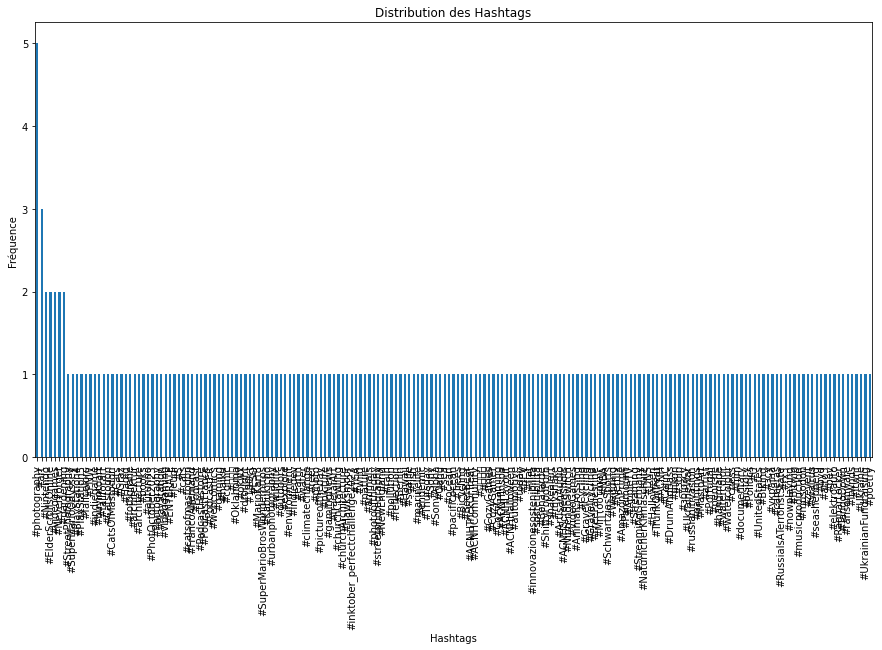

In [198]:
hashtags_counts = df.value_counts()

plt.figure(figsize=(15, 8))
hashtags_counts.plot(kind='bar')
plt.title('Distribution des Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Fréquence')
plt.show()

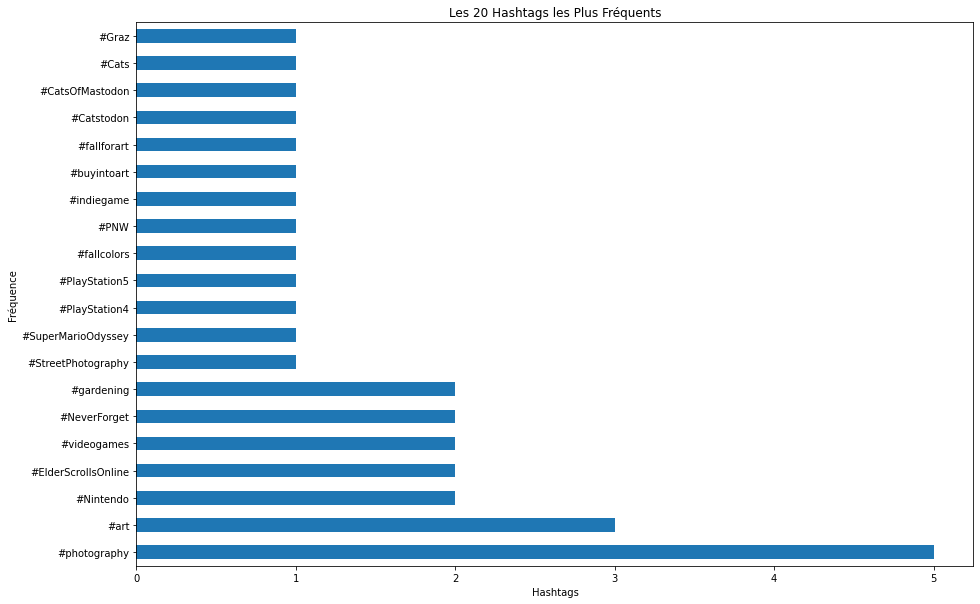

In [199]:
top_20_hashtags = hashtags_counts.nlargest(20)

plt.figure(figsize=(15,10))
top_20_hashtags.plot(kind='barh')
plt.title('Les 20 Hashtags les Plus Fréquents')
plt.xlabel('Hashtags')
plt.ylabel('Fréquence')
plt.show()

## Après traitements

In [200]:
with open(f'liste_hashtags_processed.pkl', 'rb') as file : 
    df_processed = pickle.load(file)

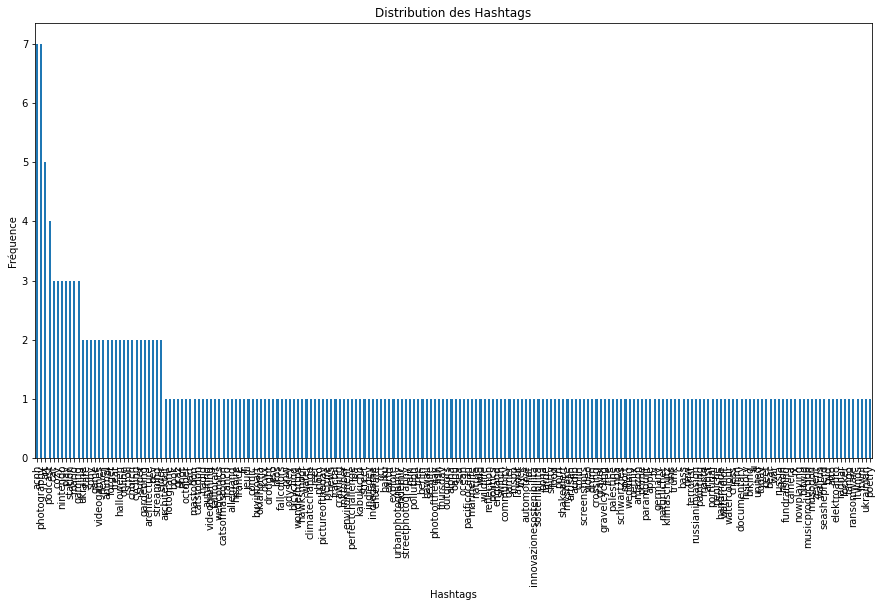

In [201]:
hashtags_counts = df_processed.value_counts()

plt.figure(figsize=(15, 8))
hashtags_counts.plot(kind='bar')
plt.title('Distribution des Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Fréquence')
plt.show()

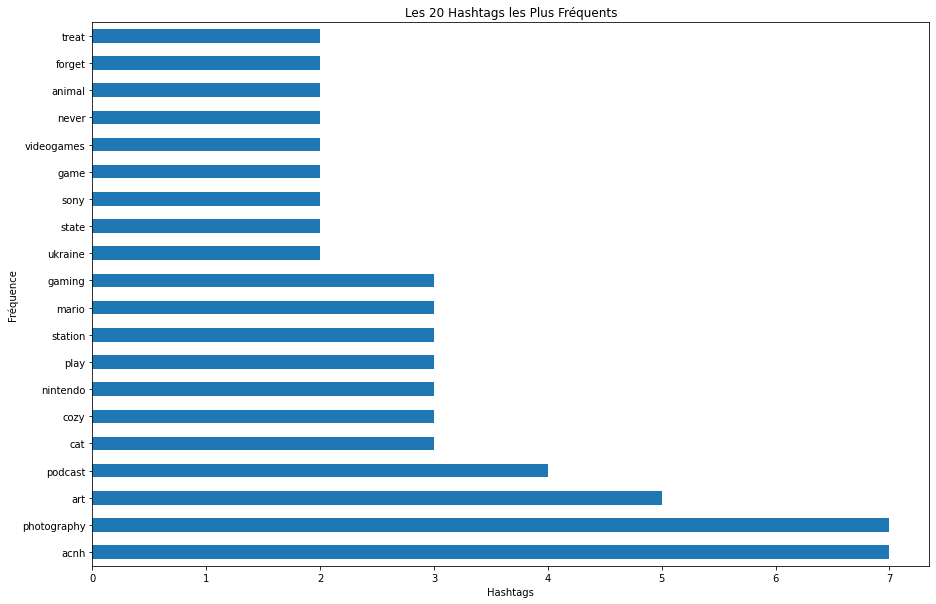

In [202]:
top_20_hashtags = hashtags_counts.nlargest(20)

plt.figure(figsize=(15,10))
top_20_hashtags.plot(kind='barh')
plt.title('Les 20 Hashtags les Plus Fréquents')
plt.xlabel('Hashtags')
plt.ylabel('Fréquence')
plt.show()